## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import XLNetTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from xlnet import CustomXLNet
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12.2 s, sys: 117 ms, total: 12.3 s
Wall time: 12.9 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_xlnet_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.xlnet, lr / 100, weight_decay)
    )

Fold 1 started at Mon Feb  3 20:56:42 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


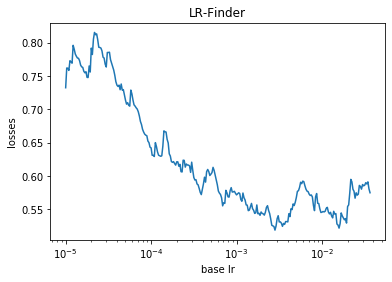

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52552 - spearmanr 0.18825
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47354 - spearmanr 0.37256


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.37256
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46647 - spearmanr 0.36327
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4544 - spearmanr 0.41358
best model: epoch 1 - 0.41358
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44591 - spearmanr 0.42217
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44898 - spearmanr 0.42089
best model: epoch 2 - 0.42089
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42898 - spearmanr 0.46984
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45111 - spearmanr 0.42115
best model: epoch 3 - 0.42115
TRAINING END: Best score achieved on epoch 3 - 0.42115
Starting inference for model: checkpoints/siamese_xlnet_2_fold_1_best.pth



Averaged Val. score: 0.4211533954411089
Starting inference for model: checkpoints/siamese_xlnet_2_fold_1_best.pth



Fold 2 started at Mon Feb  3 22:17:57 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52721 - spearmanr 0.18344
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48733 - spearmanr 0.35947
best model: epoch 0 - 0.35947
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46629 - spearmanr 0.36316
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46227 - spearmanr 0.40915
best model: epoch 1 - 0.40915
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44674 - spearmanr 0.41973
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.451 - spearmanr 0.42298
best model: epoch 2 - 0.42298
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.429 - spearmanr 0.46623
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45227 - spearmanr 0.42813
best model: epoch 3 - 0.42813
TRAINING END: Best score achieved on epoch 3 - 0.42813
Starting inference for model: checkpoints/siamese_xlnet_2_fold_2_best.pth



Averaged Val. score: 0.42812555134150876
Starting inference for model: checkpoints/siamese_xlnet_2_fold_2_best.pth



Fold 3 started at Mon Feb  3 23:37:08 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52501 - spearmanr 0.18679
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47315 - spearmanr 0.36961
best model: epoch 0 - 0.36961
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46629 - spearmanr 0.36488
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45832 - spearmanr 0.40253
best model: epoch 1 - 0.40253
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44511 - spearmanr 0.42542
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45272 - spearmanr 0.41377
best model: epoch 2 - 0.41377
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42841 - spearmanr 0.46979
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45465 - spearmanr 0.41501
best model: epoch 3 - 0.41501
TRAINING END: Best score achieved on epoch 3 - 0.41501
Starting inference for model: checkpoints/siamese_xlnet_2_fold_3_best.pth



Averaged Val. score: 0.4150116955764409
Starting inference for model: checkpoints/siamese_xlnet_2_fold_3_best.pth



Fold 4 started at Tue Feb  4 00:56:25 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52727 - spearmanr 0.18514
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47531 - spearmanr 0.34458
best model: epoch 0 - 0.34458
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46674 - spearmanr 0.36276
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4591 - spearmanr 0.38957
best model: epoch 1 - 0.38957
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44599 - spearmanr 0.42251
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45603 - spearmanr 0.40141
best model: epoch 2 - 0.40141
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4304 - spearmanr 0.4646
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45293 - spearmanr 0.40566
best model: epoch 3 - 0.40566
TRAINING END: Best score achieved on epoch 3 - 0.40566
Starting inference for model: checkpoints/siamese_xlnet_2_fold_4_best.pth



Averaged Val. score: 0.4056572855816164
Starting inference for model: checkpoints/siamese_xlnet_2_fold_4_best.pth



Fold 5 started at Tue Feb  4 02:14:54 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52851 - spearmanr 0.17876
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47116 - spearmanr 0.35658
best model: epoch 0 - 0.35658
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46622 - spearmanr 0.36653
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45556 - spearmanr 0.39324
best model: epoch 1 - 0.39324
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44513 - spearmanr 0.42733
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44964 - spearmanr 0.40605
best model: epoch 2 - 0.40605
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42801 - spearmanr 0.47318
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45087 - spearmanr 0.40394
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40605
Starting inference for model: checkpoints/siamese_xlnet_2_fold_5_best.pth



Averaged Val. score: 0.4060484688571397
Starting inference for model: checkpoints/siamese_xlnet_2_fold_5_best.pth



Fold 6 started at Tue Feb  4 03:33:21 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52702 - spearmanr 0.1837
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46758 - spearmanr 0.35715
best model: epoch 0 - 0.35715
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46706 - spearmanr 0.36443
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45004 - spearmanr 0.39144
best model: epoch 1 - 0.39144
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44651 - spearmanr 0.42418
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44951 - spearmanr 0.39103
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43033 - spearmanr 0.46743
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44952 - spearmanr 0.3935
best model: epoch 3 - 0.3935
TRAINING END: Best score achieved on epoch 3 - 0.39350
Starting inference for model: checkpoints/siamese_xlnet_2_fold_6_best.pth



Averaged Val. score: 0.39349747824354875
Starting inference for model: checkpoints/siamese_xlnet_2_fold_6_best.pth



Fold 7 started at Tue Feb  4 04:51:49 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52725 - spearmanr 0.17672
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49166 - spearmanr 0.35793
best model: epoch 0 - 0.35793
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46732 - spearmanr 0.36088
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46238 - spearmanr 0.40576
best model: epoch 1 - 0.40576
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44693 - spearmanr 0.42052
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45485 - spearmanr 0.41526
best model: epoch 2 - 0.41526
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43011 - spearmanr 0.46464
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45534 - spearmanr 0.41845
best model: epoch 3 - 0.41845
TRAINING END: Best score achieved on epoch 3 - 0.41845
Starting inference for model: checkpoints/siamese_xlnet_2_fold_7_best.pth



Averaged Val. score: 0.41844513362146685
Starting inference for model: checkpoints/siamese_xlnet_2_fold_7_best.pth



Fold 8 started at Tue Feb  4 06:10:26 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52653 - spearmanr 0.18246
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48058 - spearmanr 0.36499
best model: epoch 0 - 0.36499
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46604 - spearmanr 0.3643
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46535 - spearmanr 0.41036
best model: epoch 1 - 0.41036
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44515 - spearmanr 0.42226
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46465 - spearmanr 0.41485
best model: epoch 2 - 0.41485
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42845 - spearmanr 0.46767
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45995 - spearmanr 0.41998
best model: epoch 3 - 0.41998
TRAINING END: Best score achieved on epoch 3 - 0.41998
Starting inference for model: checkpoints/siamese_xlnet_2_fold_8_best.pth



Averaged Val. score: 0.4199809938963163
Starting inference for model: checkpoints/siamese_xlnet_2_fold_8_best.pth



Fold 9 started at Tue Feb  4 07:29:09 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52468 - spearmanr 0.18961
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47039 - spearmanr 0.3584
best model: epoch 0 - 0.3584
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46584 - spearmanr 0.36776
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46197 - spearmanr 0.39387
best model: epoch 1 - 0.39387
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44629 - spearmanr 0.42224
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44949 - spearmanr 0.40946
best model: epoch 2 - 0.40946
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.42846 - spearmanr 0.47119
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45066 - spearmanr 0.41272
best model: epoch 3 - 0.41272
TRAINING END: Best score achieved on epoch 3 - 0.41272
Starting inference for model: checkpoints/siamese_xlnet_2_fold_9_best.pth



Averaged Val. score: 0.41272145824476614
Starting inference for model: checkpoints/siamese_xlnet_2_fold_9_best.pth



Fold 10 started at Tue Feb  4 08:47:55 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52748 - spearmanr 0.17901
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47039 - spearmanr 0.37242
best model: epoch 0 - 0.37242
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46817 - spearmanr 0.36092
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44705 - spearmanr 0.41439
best model: epoch 1 - 0.41439
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44698 - spearmanr 0.42269
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44458 - spearmanr 0.42461
best model: epoch 2 - 0.42461
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43039 - spearmanr 0.46644
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4428 - spearmanr 0.42592
best model: epoch 3 - 0.42592
TRAINING END: Best score achieved on epoch 3 - 0.42592
Starting inference for model: checkpoints/siamese_xlnet_2_fold_10_best.pth



Averaged Val. score: 0.4259227863436634
Starting inference for model: checkpoints/siamese_xlnet_2_fold_10_best.pth



OOF score: 0.41484092933845745


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomXLNet(256, cat_features_train.shape[1], head_dropout=0.5)
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))
#     scheduler = transformers.get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=2736, num_training_steps=n_epochs*2736+1)

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.48465568846093116
4 8 0.36841296272309443
5 4 0.4646870754559907
9 64 0.12770746593371543
11 8 0.755746729628279
12 4 0.5485197495696122
13 4 0.3044714131704583
14 8 0.6348269444071761
15 8 0.5936039766777589
19 64 0.21637464290433303


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8,  8,  4, 64,  8,  4,  4,  8,  8, 64]),
 array([ 2,  4,  5,  9, 11, 12, 13, 14, 15, 19]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.414841
CV unique rows,0.379903
CV ignoring hard targets,0.438940
CV unique rows ignoring hard targets,0.401580
CV w rounding,0.448208
CV unique rows w rounding,0.425130
CV ignoring hard targets w rounding,0.467934
CV unique rows ignoring hard targets w rounding,0.439677


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.418782
CV unique rows,0.384076
CV ignoring hard targets,0.438940
CV unique rows ignoring hard targets,0.401580
CV w rounding,0.448952
CV unique rows w rounding,0.425848
CV ignoring hard targets w rounding,0.467934
CV unique rows ignoring hard targets w rounding,0.439677


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.825581,0.639256,0.411106,0.456817,0.490095,0.418817,0.666710,0.682033,0.654706,0.002345,0.762357,0.783591,0.023512,0.209396,0.003041,0.007494,0.029832,0.072751,0.828949,0.000371,0.862625,0.698214,0.281375,0.831093,0.829275,0.471091,0.007440,0.018418,0.853383,0.742790
1,46,0.494827,0.308210,0.004638,0.681259,0.702111,0.900541,0.400167,0.286215,0.124857,0.007463,0.430832,0.467171,0.003332,0.000918,0.000895,0.009565,0.875747,0.370446,0.094480,0.000131,0.263278,0.805787,0.508135,0.869604,0.904799,0.593400,0.911224,0.329734,0.101375,0.578957
2,70,0.767271,0.729978,0.036149,0.750231,0.833567,0.906088,0.557396,0.449700,0.177992,0.004821,0.236302,0.846290,0.012800,0.047747,0.004024,0.005175,0.118302,0.105823,0.598241,0.000753,0.806337,0.729830,0.383115,0.833787,0.851181,0.574756,0.032321,0.053218,0.823767,0.691595
3,132,0.624447,0.238774,0.004818,0.596653,0.628499,0.848035,0.424126,0.278026,0.252473,0.006669,0.596267,0.093334,0.001093,0.001475,0.000489,0.003063,0.847908,0.295288,0.633970,0.000060,0.434006,0.781221,0.597661,0.864342,0.912205,0.631354,0.861559,0.312701,0.594041,0.572734
4,200,0.786756,0.346369,0.043708,0.725123,0.764719,0.839490,0.628002,0.646474,0.452518,0.006398,0.389540,0.793838,0.008634,0.019537,0.003678,0.043845,0.224734,0.177616,0.677737,0.001531,0.551855,0.775247,0.529775,0.880942,0.880419,0.609074,0.319565,0.270322,0.655785,0.663309


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.859366,0.715242,0.236371,0.635249,0.565313,0.364347,0.677246,0.644374,0.121128,0.006316,0.639190,0.113115,0.313316,0.041309,0.020870,0.215980,0.145908,0.117261,0.430440,0.002480,0.801057,0.898419,0.581086,0.962357,0.948801,0.753449,0.107356,0.093183,0.840183,0.750360
1,0.857327,0.681035,0.021644,0.552508,0.941306,0.708669,0.583843,0.743367,0.576233,0.000828,0.231201,0.106615,0.826997,0.005586,0.767042,0.027707,0.069619,0.090274,0.372868,0.008228,0.753681,0.508489,0.253907,0.735667,0.773217,0.334273,0.014180,0.033798,0.453693,0.777680
2,0.611831,0.344681,0.005592,0.685959,0.787666,0.867311,0.413123,0.232524,0.109086,0.003126,0.357570,0.143909,0.002250,0.001308,0.001283,0.256935,0.717839,0.243527,0.154270,0.000105,0.568737,0.862873,0.608923,0.912700,0.923557,0.675479,0.656770,0.301090,0.521876,0.796801
3,0.821571,0.748045,0.064000,0.866125,0.819970,0.903609,0.597293,0.644660,0.283768,0.001181,0.228129,0.967682,0.024803,0.014434,0.040383,0.023409,0.054723,0.077368,0.331282,0.001375,0.784621,0.879124,0.749326,0.908130,0.929192,0.805300,0.031452,0.089235,0.905851,0.723507
4,0.829079,0.841627,0.002912,0.672615,0.791915,0.880651,0.526466,0.455949,0.227632,0.000383,0.383870,0.438372,0.001255,0.000462,0.000315,0.003318,0.900868,0.312308,0.086438,0.000021,0.855392,0.803317,0.450044,0.885130,0.894893,0.595164,0.905341,0.254198,0.051141,0.643691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.855572,0.612079,0.206476,0.715925,0.674337,0.629342,0.673107,0.644670,0.664609,0.002319,0.560678,0.938107,0.146430,0.353761,0.007019,0.083071,0.015327,0.043652,0.756418,0.002706,0.782407,0.896344,0.724561,0.943610,0.921293,0.738144,0.099284,0.089771,0.917776,0.769079
6075,0.818222,0.365847,0.061737,0.484601,0.546660,0.398755,0.749976,0.722313,0.072728,0.002039,0.734511,0.010116,0.006219,0.003342,0.001312,0.014289,0.819082,0.446938,0.212984,0.000073,0.699919,0.841457,0.602986,0.908693,0.916716,0.622864,0.833370,0.426626,0.235350,0.858984
6076,0.648358,0.444178,0.009613,0.657820,0.718410,0.861652,0.441459,0.336807,0.243262,0.002178,0.481163,0.765510,0.005663,0.002107,0.000600,0.010758,0.820207,0.355410,0.159491,0.000102,0.592373,0.633815,0.457466,0.829779,0.800594,0.440723,0.689443,0.212133,0.570010,0.532412
6077,0.860426,0.746884,0.851243,0.168681,0.180675,0.057396,0.674515,0.802751,0.693552,0.001646,0.945428,0.692471,0.148743,0.099780,0.005658,0.022106,0.007207,0.220656,0.709851,0.000300,0.927553,0.795023,0.638286,0.856120,0.902091,0.635830,0.014145,0.144118,0.905055,0.866728


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.391098
question_body_critical                   0.620428
question_conversational                  0.419537
question_expect_short_answer             0.308271
question_fact_seeking                    0.365714
question_has_commonly_accepted_answer    0.434567
question_interestingness_others          0.363973
question_interestingness_self            0.508937
question_multi_intent                    0.585180
question_not_really_a_question           0.086374
question_opinion_seeking                 0.481563
question_type_choice                     0.743090
question_type_compare                    0.365326
question_type_consequence                0.190375
question_type_definition                 0.363346
question_type_entity                     0.461143
question_type_instructions               0.783345
question_type_procedure                  0.369908
question_type_reason_explanation         0.670964
question_type_spelling                   0.068536


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.068536,3.0
question_not_really_a_question,0.086374,5.0
answer_plausible,0.147585,9.0
answer_relevance,0.173441,9.0
question_type_consequence,0.190375,5.0
answer_well_written,0.225913,9.0
answer_helpful,0.243337,9.0
question_expect_short_answer,0.308271,5.0
answer_type_procedure,0.310451,5.0
answer_satisfaction,0.350168,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

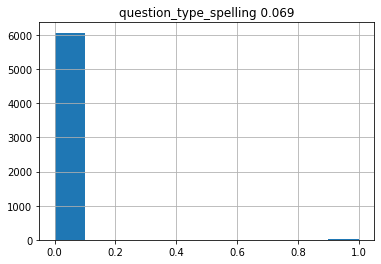

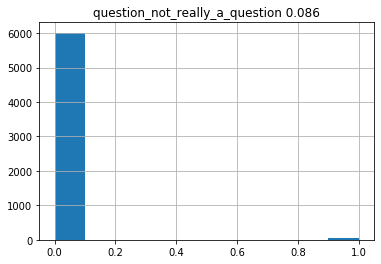

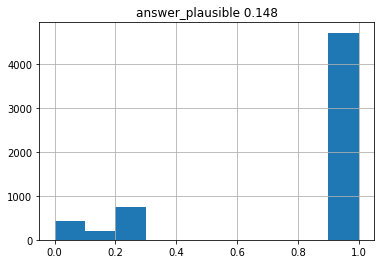

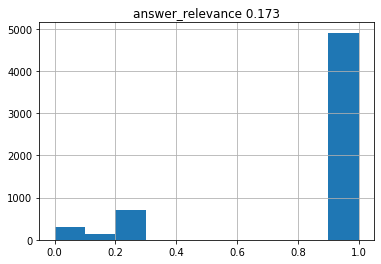

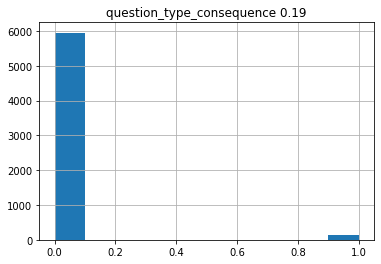

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


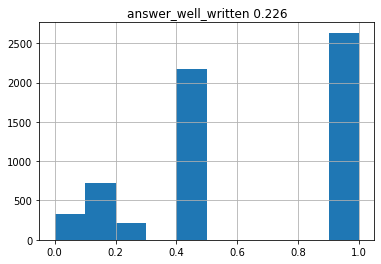

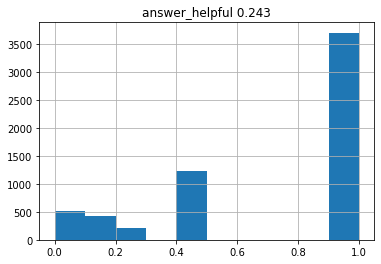

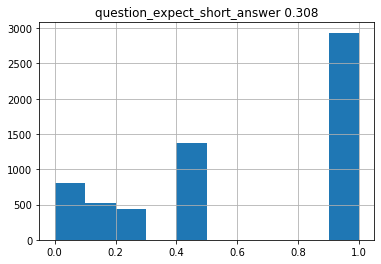

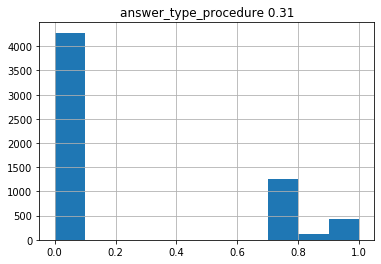

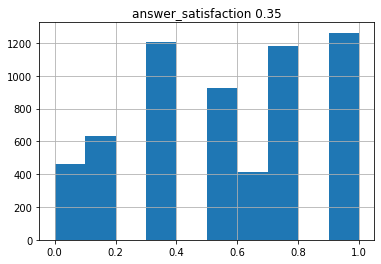

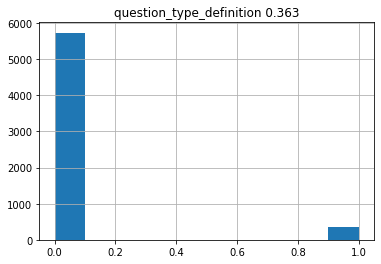

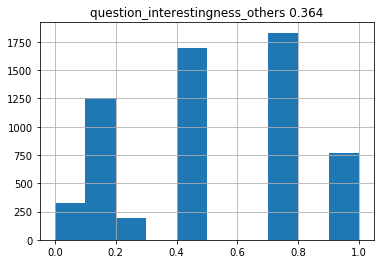

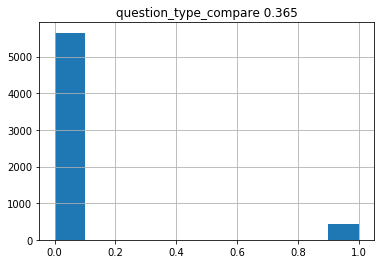

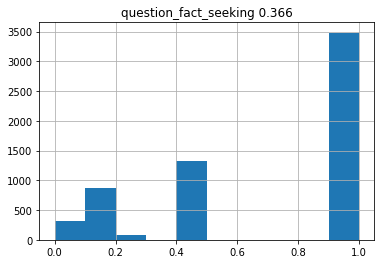

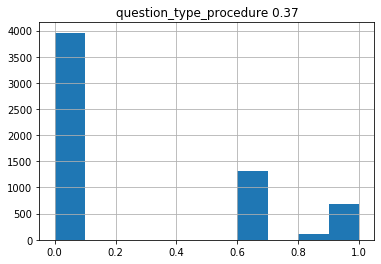

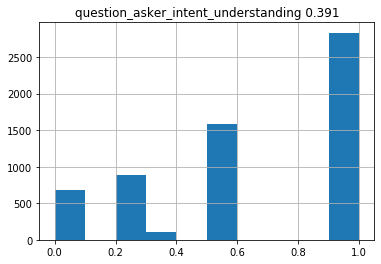

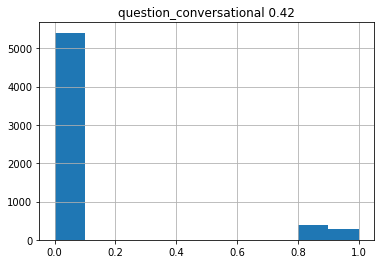

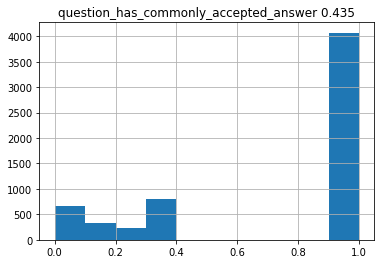

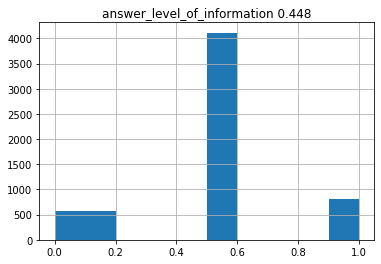

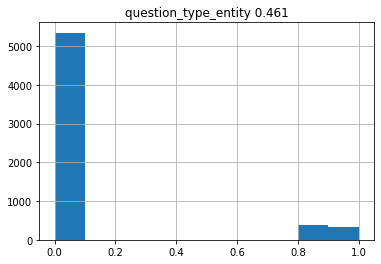

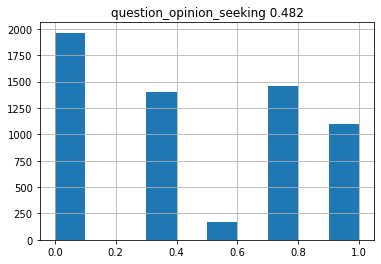

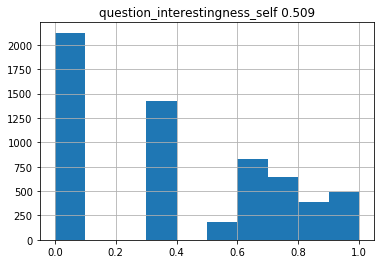

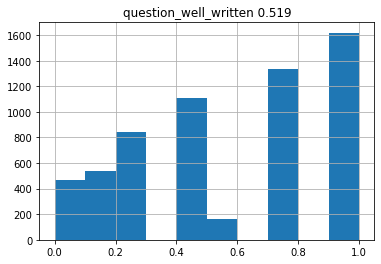

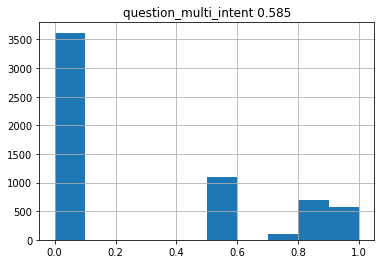

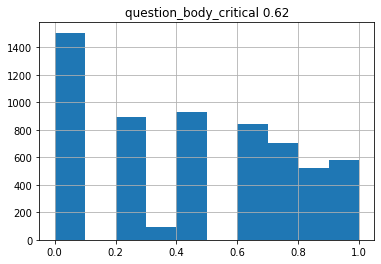

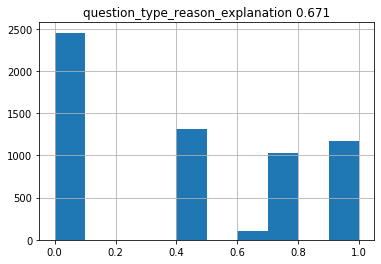

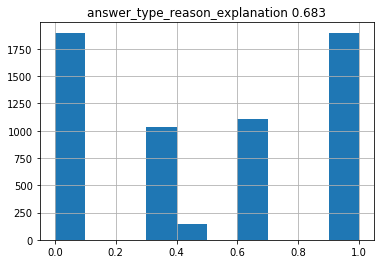

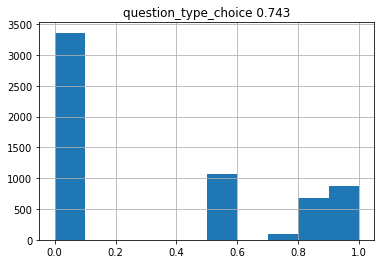

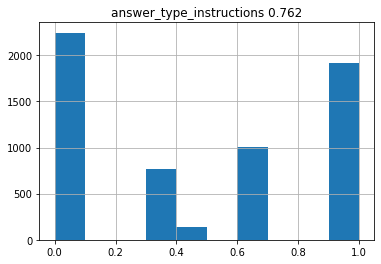

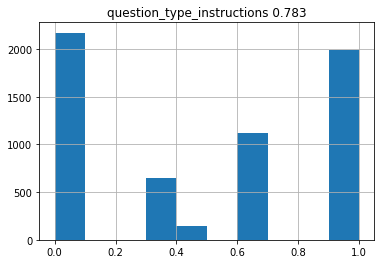

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')